## Sistema de recomendación de peliculas

**Integrantes**
1) Alan Grez

2) Mario Mallea

3) Hugo Rocha

4) Maximiliano Ramírez

Importamos las librerias necesarias

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

In [2]:
preprocesado = pd.read_csv(os.path.join("data","Datos_Proyecto_Aplica.csv"))

Análisis Exploratorio

Importamos el módulo de gráficos

In [3]:
import graficos as gr

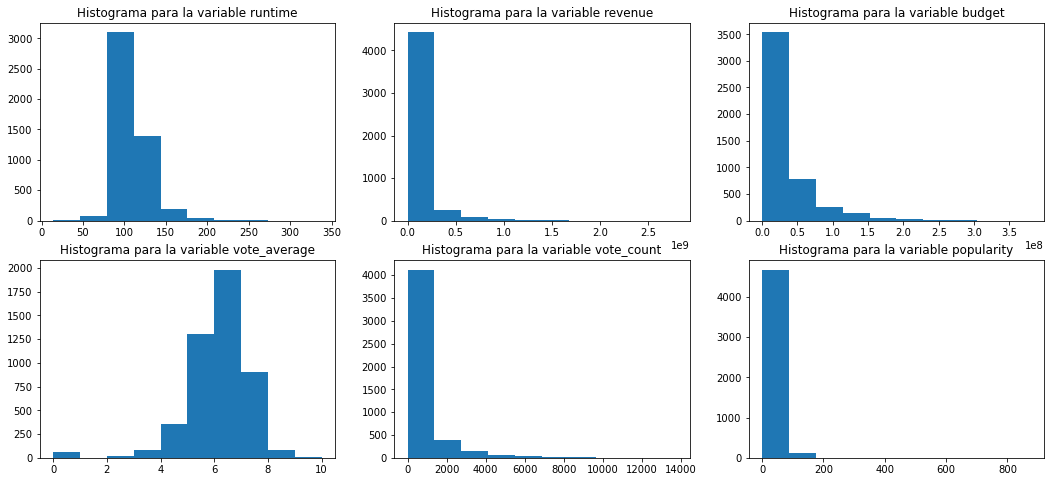

In [4]:
gr.graphics1()

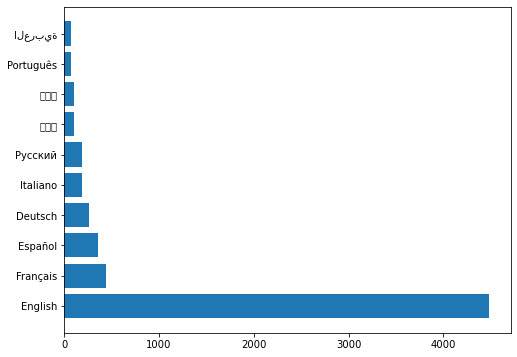

In [5]:
plt.figure(figsize=(8,6))
gr.graphics2()

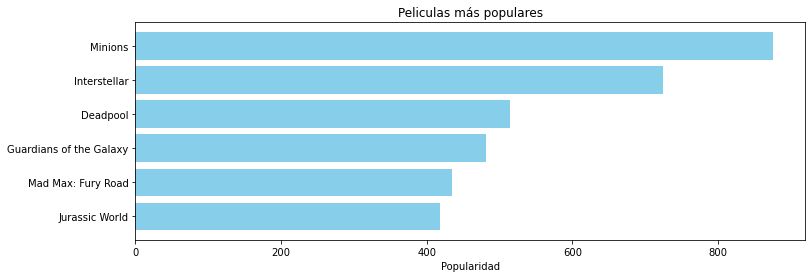

In [6]:
gr.graphics3()

Veamos el top 10 películas con más votos y mejor valorados.

In [7]:
q_movies = preprocesado.sort_values('vote_count', ascending=False)
q_movies[['title', 'vote_count', 'vote_average']].head(20)

,title,vote_count,vote_average
96,Inception,13752,8.1
65,The Dark Knight,12002,8.2
0,Avatar,11800,7.2
16,The Avengers,11776,7.4
788,Deadpool,10995,7.4
95,Interstellar,10867,8.1
287,Django Unchained,10099,7.8
94,Guardians of the Galaxy,9742,7.9
426,The Hunger Games,9455,6.9
127,Mad Max: Fury Road,9427,7.2


In [8]:
q_movies = preprocesado.sort_values('vote_average', ascending=False)

q_movies[['title', 'vote_count', 'vote_average']].head(10)

,title,vote_count,vote_average
3519,Stiff Upper Lips,1,10.0
4247,Me You and Five Bucks,2,10.0
4045,"Dancer, Texas Pop. 81",1,10.0
4662,Little Big Top,1,10.0
3992,Sardaarji,2,9.5
2386,One Man's Hero,2,9.3
2970,There Goes My Baby,2,8.5
1881,The Shawshank Redemption,8205,8.5
2796,The Prisoner of Zenda,11,8.4
3337,The Godfather,5893,8.4


Aquí vemos que no son comparables los top, por lo que estableceremos la media geométrica entre estas para poder compararlas.

In [9]:
preprocesado["Score"]= np.sqrt(preprocesado["vote_average"]* preprocesado["vote_count"])

In [10]:

q_movies = preprocesado.sort_values('Score', ascending=False)

q_movies[['title', 'vote_count', 'vote_average','Score']].head(30)

,title,vote_count,vote_average,Score
96,Inception,13752,8.1,333.753202
65,The Dark Knight,12002,8.2,313.713882
95,Interstellar,10867,8.1,296.686198
16,The Avengers,11776,7.4,295.198916
0,Avatar,11800,7.2,291.478987
788,Deadpool,10995,7.4,285.242003
287,Django Unchained,10099,7.8,280.663856
662,Fight Club,9413,8.3,279.513685
94,Guardians of the Galaxy,9742,7.9,277.419898
634,The Matrix,8907,7.9,265.264585


Construcción de funciones

In [11]:
def lista_recomendados(idx , col):
    
    #Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
    tfidf = TfidfVectorizer(stop_words='english')
    #Replace NaN with an empty string
    preprocesado[col] = preprocesado[col].fillna('')
    #Construct the required TF-IDF matrix by fitting and transforming the data
    tfidf_matrix = tfidf.fit_transform(preprocesado[col])
    # Compute the cosine similarity matrix
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    # Return the top 10 most similar movies
    return sim_scores

## Kmeans con variables numericas

In [12]:
numeric_features = list(preprocesado.dtypes[preprocesado.dtypes != "object"].index)
numericas_prepro=preprocesado[numeric_features].iloc[:,1:].drop(["id","vote_average","vote_count"],axis=1)

#imputamos por el promedio los dos perdidos
is_NaN = numericas_prepro.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = numericas_prepro[row_has_NaN]
numericas_prepro.loc[numericas_prepro[row_has_NaN].index,"runtime"]= numericas_prepro.runtime.mean()

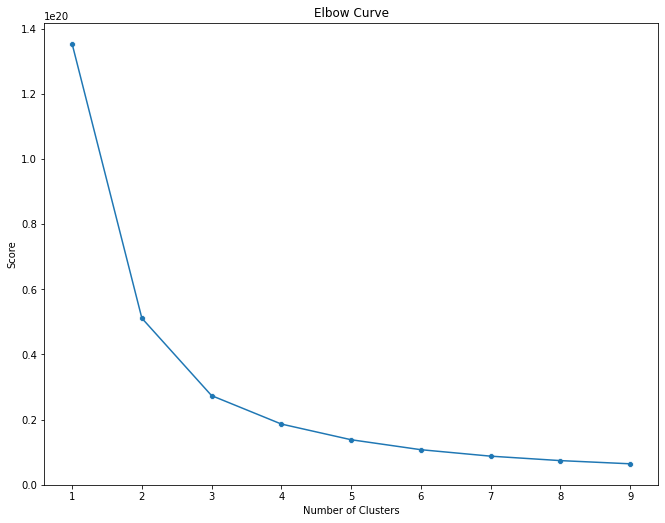

In [13]:
# implementación de la regla del codo
gr.kme()

In [14]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(numericas_prepro.iloc[:,1:])

## Análisis de otras variables.

In [15]:
import ast
generos=[]
for i in preprocesado.genres:
    i=ast.literal_eval(i)
    for j in i:
        if j not in generos:
            generos.append(j)

In [16]:
generos

['Action',
 'Adventure',
 'Fantasy',
 'Science Fiction',
 'Crime',
 'Drama',
 'Thriller',
 'Animation',
 'Family',
 'Western',
 'Comedy',
 'Romance',
 'Horror',
 'Mystery',
 'History',
 'War',
 'Music',
 'Documentary',
 'Foreign',
 'TV Movie']

production_companies

In [17]:
import ast
prod_comp=[]
for i in preprocesado.production_companies:
    i=ast.literal_eval(i)
    for j in i:
        if j not in prod_comp:
            prod_comp.append(j)

In [18]:
len(prod_comp)

5017

paises_prod

In [19]:
import ast
prod_count=[]
for i in preprocesado.production_countries:
    i=ast.literal_eval(i)
    for j in i:
        if j not in prod_count:
            prod_count.append(j)
len(prod_count)

88

idiomas

In [20]:

import ast
leng=[]
for i in preprocesado.spoken_languages:
    i=ast.literal_eval(i)
    for j in i:
        if j not in leng:
            leng.append(j)
len(leng)

62

In [21]:
def top_inter(indice_pelicula):
    top=[]
    generos_pelicula    = ast.literal_eval(preprocesado.genres[indice_pelicula]              )
    prod_pelicula       = ast.literal_eval(preprocesado.production_companies[indice_pelicula])
    prod_pais_pelicula  = ast.literal_eval(preprocesado.production_countries[indice_pelicula])
    leng_pelicula       = ast.literal_eval(preprocesado.spoken_languages[indice_pelicula]    )
    
    for i in range(preprocesado.shape[0]):
        generos_2_peliculas   = ast.literal_eval(preprocesado.genres[i]              )
        prod_2_peliculas      = ast.literal_eval(preprocesado.production_companies[i])
        prod_pais_2_peliculas = ast.literal_eval(preprocesado.production_countries[i])
        leng_2_pelicula       = ast.literal_eval(preprocesado.spoken_languages[i]    )
        
        
        interseccion_gen       = len(list(set(generos_pelicula)   & set(generos_2_peliculas  )))
        interseccion_prod      = len(list(set(prod_pelicula)      & set(prod_2_peliculas     )))
        interseccion_prod_pais = len(list(set(prod_pais_pelicula) & set(prod_pais_2_peliculas)))
        interseccion_leng      = len(list(set(leng_pelicula)      & set(leng_2_pelicula      )))
        
        top.append([i,preprocesado.title[i],interseccion_gen, int(interseccion_prod),int(interseccion_prod_pais), int(interseccion_leng)])
        
    top_df =pd.DataFrame(data=np.array(top),columns=["pelicula_fila","title","generos_en_comun","productora_en_comun","pais_prod_en_comun","idiomas_en_comun"])
    top_df["productora_en_comun"]=top_df["productora_en_comun"].astype(int)
    top_df["generos_en_comun"]=top_df["generos_en_comun"].astype(int)
    top_df["pelicula_fila"]=top_df["pelicula_fila"].astype(int)
    
    return top_df[(top_df["generos_en_comun"] >0 )& (top_df["productora_en_comun"]> 0 )]        
    

In [22]:
top_inter(65)

,pelicula_fila,title,generos_en_comun,productora_en_comun,pais_prod_en_comun,idiomas_en_comun
3,3,The Dark Knight Rises,4,4,1,1
9,9,Batman v Superman: Dawn of Justice,1,3,1,1
10,10,Superman Returns,1,3,1,1
14,14,Man of Steel,1,4,2,1
28,28,Jurassic World,2,1,1,1
...,...,...,...,...,...,...
3911,3911,Krush Groove,1,1,1,1
4172,4172,A Streetcar Named Desire,1,1,1,1
4267,4267,Batman,1,1,1,1
4312,4312,The Charge of the Light Brigade,2,1,1,1


In [23]:
def fechas_limites(indice_pelicula):
    peliculas_cercanas=[]
    fecha=pd.to_datetime(preprocesado.release_date)
    fecha_pelicula= fecha[indice_pelicula]
    for i in range(fecha.shape[0]):
        if fecha[i].year +15 >fecha_pelicula.year and fecha[i].year-15 <fecha_pelicula.year:
            peliculas_cercanas.append([i,fecha[i],preprocesado.title[i]])
    peliculas_cercanas =pd.DataFrame(data=np.array(peliculas_cercanas),columns=["pelicula_fila","fecha","title"])
    return peliculas_cercanas
            

In [24]:
fechas_limites(65)

,pelicula_fila,fecha,title
0,0,2009-12-10,Avatar
1,1,2007-05-19,Pirates of the Caribbean: At World's End
2,2,2015-10-26,Spectre
3,3,2012-07-16,The Dark Knight Rises
4,4,2012-03-07,John Carter
...,...,...,...
4127,4797,2005-03-12,Cavite
4128,4799,2011-12-26,Newlyweds
4129,4800,2013-10-13,"Signed, Sealed, Delivered"
4130,4801,2012-05-03,Shanghai Calling


In [25]:
def find_director(indice_pelicula):
    crew_pel = ast.literal_eval(preprocesado.job[indice_pelicula])
    for i in range(len(crew_pel)):
        if crew_pel[i] == 'Director':
            break
    director_por_buscar = ast.literal_eval(preprocesado.name_crew[indice_pelicula])[i]
    df_aux= preprocesado[preprocesado[['name_crew']].applymap(lambda x: director_por_buscar in x ).name_crew]
    return df_aux[['title', 'Unnamed: 0']].rename(columns = {'Unnamed: 0': 'pelicula_fila'})
    

In [26]:
find_director(65)

,title,pelicula_fila
3,The Dark Knight Rises,3
9,Batman v Superman: Dawn of Justice,9
14,Man of Steel,14
65,The Dark Knight,65
95,Interstellar,95
96,Inception,96
119,Batman Begins,119
333,Transcendence,333
1033,Insomnia,1033
1196,The Prestige,1196


In [27]:
def find_actores(indice_pelicula):
    aux = []
    actores = set(ast.literal_eval(preprocesado.name_cast[indice_pelicula])[:10])
    for i in range(preprocesado.shape[0]):
        condicion = list((i,preprocesado.title[i], len(actores & set(ast.literal_eval(preprocesado.name_cast[i])[:10]))))
        if preprocesado.title[i] != preprocesado.title[indice_pelicula]:
            aux.append( condicion )
    df_aux = pd.DataFrame(data = np.array(aux), columns= ['pelicula_fila','title','actores_comunes'])
    df_aux["actores_comunes"] = df_aux["actores_comunes"].astype(int)
    df_aux["pelicula_fila"] = df_aux["pelicula_fila"].astype(int)
    return  df_aux[ df_aux.actores_comunes > 0]


In [28]:
find_actores(65)

,pelicula_fila,title,actores_comunes
3,3,The Dark Knight Rises,5
40,40,Cars 2,1
43,43,Terminator Salvation,1
60,60,A Christmas Carol,1
72,73,Evan Almighty,1
...,...,...,...
4098,4099,Harsh Times,1
4129,4130,Sherrybaby,1
4537,4538,Finishing The Game,1
4566,4567,Conversations with Other Women,1


In [29]:
def juntar(df1, df2, df3):
    #Asumimos que df1: top_inter, df2: find_actores, df3: find_director
    pel_fil = set()
    data= pd.DataFrame(columns=['pelicula_fila', 'title', 'generos_en_comun', 'productora_en_comun',
       'pais_prod_en_comun', 'idiomas_en_comun', 'actores_comunes', 'director_en_comun'])
    
    for x in df1.pelicula_fila:
        pel_fil.add(x)
    
    for x in df2.pelicula_fila:
        pel_fil.add(x)
        
    for x in df3.pelicula_fila:
        pel_fil.add(x)
    
    for i in list(pel_fil):
        if i in list(df1.pelicula_fila):
            a= list(df1.loc[i, ['pelicula_fila', 'title', 'generos_en_comun', 'productora_en_comun',
       'pais_prod_en_comun', 'idiomas_en_comun']])
            if i in list(df2.pelicula_fila):
                a= a+ list(df2[df2['pelicula_fila']==i].actores_comunes)
                if i in list(df3.pelicula_fila):
                    a+=[1]
                else:
                    a+=[0]
            else:
                a+= [0]
                if i in list(df3.pelicula_fila):
                    a+=[1]
                    data.loc[i]=a
                else:
                    a+=[0]
                    data.loc[i]=a
        else:
            if i in list(df2.pelicula_fila):
                a= [i] + list(df2[df2['pelicula_fila']==i].title) +[0, 0, 0 ,0]
            else:
                a= [i] + list(df3[df3['pelicula_fila']==i].title) +[0, 0, 0 ,0]
            if i in list(df2.pelicula_fila):
                a+= list(df2[df2['pelicula_fila']==i].actores_comunes)
                if i in list(df3.pelicula_fila):
                    a+=[1]
                    data.loc[i]=a
                else:
                    a+=[0]
                    data.loc[i]=a
            else:
                a+= [0]
                if i in list(df3.pelicula_fila):
                    a+=[1]
                    data.loc[i]=a
                else:
                    a+=[0]
                    data.loc[i]=a
    
    
    return data

In [30]:
def concatenar(indice_pelicula):
    df_aux = juntar(top_inter(indice_pelicula), find_actores(indice_pelicula), find_director(indice_pelicula))
    for i in df_aux.columns[2:-2]:
        df_aux[i] = df_aux[i].astype(int)
    
    df_aux['score'] = df_aux[['generos_en_comun', 'productora_en_comun', 'pais_prod_en_comun', 'idiomas_en_comun','actores_comunes']].sum(axis = 1)
    
    return df_aux[['pelicula_fila','title','score', 'director_en_comun']].sort_values(by=['score'], ascending=False)

In [31]:
concatenar(65)

,pelicula_fila,title,score,director_en_comun
65,65,The Dark Knight,13.0,1
14,14,Man of Steel,8.0,1
1892,1892,The Losers,8.0,0
758,758,Edge of Darkness,7.0,0
164,164,Lethal Weapon 4,7.0,0
...,...,...,...,...
1043,1043,Miss Congeniality,1.0,0
191,191,Harry Potter and the Prisoner of Azkaban,1.0,0
4099,4099,Harsh Times,1.0,0
1033,1033,Insomnia,0.0,1


>Hasta ahora contamos con los siguientes recomendadores (Cosenosimilaridad de texto):

1) overview \
2) keywords \
3) Title + Tagline

>Tenemos clusters generados por K-mean generado a través de todas la variables numéricas asociados a cada película:

1) budget \
2) popularity \
3) revenue \
4) runtime \
5) vote_average \
6) vote_count \
7) Score (Promedio geometrico entre 5 y 6.) 

>Tenemos un filtro por fecha con restricción de 15 años de diferencia.

>Contamos con un filtro que trabaja con el lenguaje original de la película.

>Finalmente contamos con una variable binaria que considera si dos películas tienes director en común y un score que considera la suma de los siguientes aspectos con respecto a una pelicula:

1) generos_en_comun : Considera cuando dos películas son del mismo género \
2) productora_en_comun : Considera cuando dos películas fueran producidas por la misma productora \
3) pais_prod_en_comun : Considera el país o los paises en comín donde dos peliculas llevaron a cabo su rodaje \
4) idiomas_en_comun : Considera cuando dos películas tiene el mismo idioma de origen en común. \
5) actores_comunes : Considera cunado dos películas tienen actores en común dentro de sus 10 papeles más protagonicos.


Dado el titula de una pelicula a para la cual se le busca asociar recomnendaciones ($T_o$), buscamos dentro de las peliculas disponibles ($T_c$) cual obtiene el mejor score cuya formula viene dada por: 

$$f_{score}(T_o,T_c)=0.7 \cdot Texto(T_o,T_c)+0.3 \cdot Kmeans(T_o,T_c) +0.6 \cdot Comunes(T_o,T_c) + Bonus(T_o,T_c)$$ \
Donde:
1) $Texto(T_o,T_c)$ es el nivel de similaridad que tiene la pelicula que se esta chequeando $T_c$ con respecto a las variables de texto (Proomedio)

2) $Kmeans(T_o,T_c)$ considera una variable binaria si se encuentran en el mismo cluster

3) $Comunes(T_o,T_c)$ Toma en cuenta el nivel de similaridad entre dos peliculas con respecto a los puntos 1-5 y sumado a esto una variable binaria que detecta cuando dos peliuclas tienen directo en comun (lo cual se beneficia con un multiplicador de 1.05 para este puntaje).

4) $Bonus(T_o,T_c)$ Considera aspectos adicionales, para los cuales se puede obtener un $10%$ de aumento sobre el puntaje final sobre el bonus y un $%5$ de aumento sobre el puntaje final previo al bonus cuando ambas peliculas cuentan con el mismo lenguaje original.

In [32]:
def text_score(idx):
    result=list()
    L_o=lista_recomendados(idx,'overview')
    mov_over = set([i[0] for i in L_o])
    score_over= [i[1] for i in L_o]
    L_k=lista_recomendados(idx,'keywords')
    mov_key = set([i[0] for i in L_k])
    score_key=[i[1] for i in L_k]
    L_mt=lista_recomendados(idx,'movies+tagline')
    mov_mt = set([i[0] for i in L_mt])
    score_mt=[i[1] for i in L_mt]
    mov_fin = mov_over|mov_key|mov_mt
    if idx in list(mov_fin):
        mov_fin.remove(idx)
    for i  in mov_fin:
        text=0
        if i in mov_over:
            if 1/score_over[list(mov_over).index(i)] == float('inf'):
                text=20
            else:
                text+=1/score_over[list(mov_over).index(i)]
        if i in mov_key:
            if 1/score_key[list(mov_key).index(i)] == float('inf'):
                text=20
            else:
                text+=1/score_over[list(mov_key).index(i)]
        if i in mov_mt:
            if 1/score_mt[list(mov_mt).index(i)] == float('inf'):
                text=20
            else:
                text+=1/score_over[list(mov_mt).index(i)]
        result.append([i,text/3])
    
    data= [[i[1]] for i in result]
    scaler = StandardScaler()
    scaler.fit(data)
    escalado = scaler.transform(data)
    
    escalado_2 = [i[0] for i in escalado]
    
    df = pd.DataFrame()
    
    df['pelicula_fila'] = list(mov_fin)
    df['score'] = escalado_2
    return df
            

In [33]:
from sklearn.preprocessing import StandardScaler

def Comunes(indice_pelicula):
    scaler = StandardScaler()
    df_aux = concatenar(indice_pelicula)
    mask = list(df_aux.director_en_comun > 0)
    df_aux.loc[mask,('score')] = df_aux.score[mask] * 1.05
    data = [[i] for i in df_aux.score]
    scaler.fit(data)
    df_aux.score = scaler.transform(data)
    return df_aux

In [34]:
def KMeans_s(indice_pelicula):
  
    mask = []
    cluster_pelicula = kmeans.predict([numericas_prepro.iloc[indice_pelicula,1:]])[0]
    for i in range(numericas_prepro.shape[0]):
        if kmeans.predict([numericas_prepro.iloc[i,1:]])[0] == kmeans.predict([numericas_prepro.iloc[indice_pelicula,1:]])[0]:
            mask.append(True)
        else:
            mask.append(False)
    return numericas_prepro.iloc[mask].index

In [35]:
def recomendador_final(nombre_pelicula):
    indice_pelicula = preprocesado.title.values.tolist().index(nombre_pelicula)
    dic = dict()
    t_s = text_score(indice_pelicula)
    com = Comunes(indice_pelicula)
    km= KMeans_s(indice_pelicula)
    fl = fechas_limites(indice_pelicula)
    lenguaje= preprocesado.original_language[indice_pelicula]
    
    for i in range(preprocesado.shape[0]):
        
        if i in list(t_s.pelicula_fila):
            dic[i] = t_s[t_s['pelicula_fila']==i].score.values[0]*0.7
            
        if i in com.pelicula_fila:
            if i in dic.keys():
                dic[i] += com[com['pelicula_fila']==i].score.values[0]*0.6
            else:
                dic[i] = com[com['pelicula_fila']==i].score.values[0]*0.6
        
        if i in list(km) :
            if i in dic.keys():
                dic[i] += dic[i]*0.3

        if i in list(fl.pelicula_fila):
            if i in dic.keys():
                dic[i] += dic[i]*0.1
            
        if lenguaje == preprocesado.original_language[i]:
            if i in dic.keys():
                dic[i] += dic[i]*0.05
    df = pd.DataFrame()
    
    df['pelicula_fila'] = list(dic.keys())
    df['scores'] = list(dic.values())
    df_f= df.sort_values(by=['scores'], ascending=False).iloc[:20,:]
    df_f['title'] = preprocesado.title[df_f.pelicula_fila].values
    
    indice = df_f[df_f['title']==nombre_pelicula].index.item()
    df_f = df_f.drop([indice],axis=0)
    
    
    return df_f

Top 10 para algunas peliculas

In [36]:
recomendador_final('Cars 2').head(10)

,pelicula_fila,scores,title
62,339,2.119675,The Incredibles
22,55,1.965806,Brave
5,5,1.842858,Spider-Man 3
4,4,1.805319,John Carter
51,231,1.715770,"Monsters, Inc."
37,118,1.715770,Ratatouille
31,88,1.715770,Big Hero 6
27,77,1.715770,Inside Out
25,66,1.715770,Up
17,42,1.715770,Toy Story 3


In [37]:
recomendador_final('Harry Potter and the Half-Blood Prince').head(10)

,pelicula_fila,scores,title
35,191,2.192929,Harry Potter and the Prisoner of Azkaban
43,276,2.046124,Harry Potter and the Chamber of Secrets
24,114,1.968485,Harry Potter and the Goblet of Fire
23,113,1.812710,Harry Potter and the Order of the Phoenix
4,14,1.614429,Man of Steel
87,744,1.241869,The Lego Movie
48,302,1.241869,Legend of the Guardians: The Owls of Ga'Hoole
29,143,1.241869,Pan
112,1078,1.241869,The Ant Bully
94,870,1.128971,Superman II


In [38]:
recomendador_final('Mulan').head(10)

,pelicula_fila,scores,title
87,812,1.624384,Pocahontas
43,289,1.624384,The Emperor's New Groove
51,358,1.624384,Atlantis: The Lost Empire
45,305,1.249526,Treasure Planet
123,1695,1.174842,Aladdin
34,194,1.174842,Dinosaur
104,1062,1.174842,A Bug's Life
78,692,1.174842,Chicken Little
69,566,1.174842,Cars
56,430,1.174842,Lilo & Stitch


In [39]:
recomendador_final('Saw').head(10)

,pelicula_fila,scores,title
71,2647,2.523460,The Midnight Meat Train
91,3537,1.955783,Wonderland
78,3230,1.955783,Repo! The Genetic Opera
86,3357,1.955783,The Devil's Rejects
85,3316,1.388106,Narc
40,1425,1.388106,Abduction
43,1486,1.388106,The Punisher
46,1654,1.388106,Godsend
84,3312,1.388106,Hostel: Part II
79,3257,1.388106,American Psycho
